# El Niño Discovery Using CFL 

Date created: 10/16/2020

Date modified: 4/5/2021

This notebook is based on a notebook created by Krzysztof Chalupka in 2016: http://people.vision.caltech.edu/~kchalupk/code.html



This notebook demonstrates how to run Causal Feature Learning (CFL) on the El Niño dataset. 
This dataset is comprised of wind speed (WS) and sea surface temperature (SST) measurements
in a region of the pacific ocean. By looking at the conditional relationship between these two variables, CFL can aggregate these low-level measurements into coarser macrovariables that represent ocean climate phenomena such as El Niño and La Niña SST patterns.



In [1]:
# imports
import os                                               # manage paths
import joblib                                           # load data
from sklearn.preprocessing import StandardScaler        # standardize data
import matplotlib.pyplot as plt                         # visualize data
from mpl_toolkits.axes_grid1 import make_axes_locatable # visualize data
from sklearn.cluster import KMeans                      # build cluster objects for CFL
from cfl.experiment import Experiment                   # run CFL

In [2]:
cfl_path = 'C:/Users/jkahn/Documents/Schmidt/cfl' #set this to your local cfl path 

## Load Data
First, we load in the data as variables X and Y, and standardize both X and Y to improve
neural network training efficiency. An example sample (WS and SST measurements at the same time point) is plotted below.

X shape: (13140, 495)
Y shape: (13140, 495)


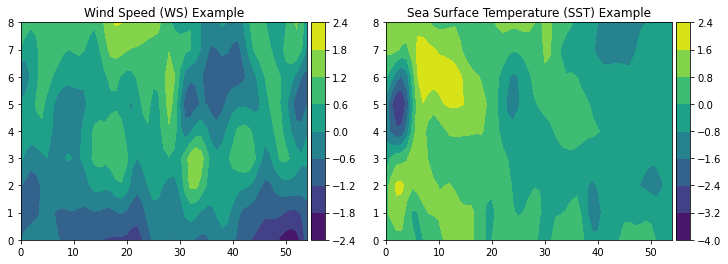

In [3]:
# load data
X, Y, coords = joblib.load(os.path.join(cfl_path, 'data/el_nino/elnino_data.pkl'))
imshape = (55, 9)
print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(Y.shape))

# standardize data
X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(Y)

# plot an example WS and SST image pair
fig,ax = plt.subplots(1,2,figsize=(12,4))

# WS plot
im0 = ax[0].contourf(X[0].reshape(imshape).T)
ax[0].set_title('Wind Speed (WS) Example')
cax0 = make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax0, orientation='vertical')

# SST plot
im1 = ax[1].contourf(Y[0].reshape(imshape).T)
ax[1].set_title('Sea Surface Temperature (SST) Example')
cax1 = make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

plt.show()

## Run CFL

CFL is composed of two main steps. First, a conditional density estimator (CDE) is used to approximate the probability of Y given X. Second, this conditional relationship is clustered to form a partitioning of X and a partitioning of Y. To run CFL, we first set parameters for each of these steps (this is done below in defining `CDE_params` and `cluster_params`).

We can then define an `Experiment` with these parameters and train it to learn a mapping from microvariables to macrovariables. 

In [4]:
# set all CFL parameters

# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape,
              'Y_type' : 'continuous'} 

# CDE parameters
lr = 1e-4
CDE_params = { 'batch_size'  : 128,
               'optimizer'   : 'adam',
               'n_epochs'    : 30,
               'verbose'     : True,
               'dense_units' : [1024, 1024, data_info['Y_dims'][1]],
               'activations' : ['linear', 'linear', 'linear'],
               'dropouts'    : [0.2, 0.2, 0.0],
}
# clusterer parameters
x_model = KMeans(n_clusters=4, random_state=0)
y_model = KMeans(n_clusters=4, random_state=0)
cluster_params = { 'x_model' : x_model, 
                   'y_model' : y_model }

save_path 'results' doesn't exist, creating now.
All results from this run will be saved to results\experiment0000
opt_config not specified in input, defaulting to {}
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True
verbose specified but not used by this block type
Training CFL pipeline.
Epoch 1/30
77/77 [==============================] - 3s 35ms/step - loss: 0.8957 - val_loss: 0.4297
Epoch 2/30
77/77 [==============================] - 2s 21ms/step - loss: 0.4823 - val_loss: 0.4239
Epoch 3/30
77/77 [==============================] - 2s 23ms/step - loss: 0.4537 - val_loss: 0.4099
Epoch 4/30
77/77 [==============================] - 2s 22ms/step - loss: 0.4459 - val_loss: 0.4198
Epoch 5/30
77/77 [==============================] - 2s 22ms/step - loss: 0.4305 - val_los

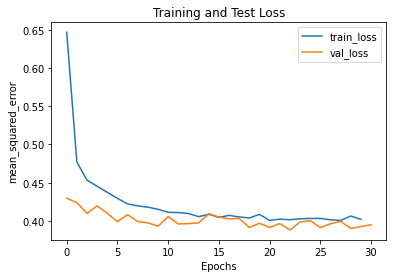

Loading parameters from  tmp_checkpoints/best_weights
Saving parameters to  results\experiment0000\trained_blocks\CondExpMod
100%|██████████| 13140/13140 [00:00<00:00, 55439.36it/s]


In [5]:
block_names = ['CondExpMod', 'Clusterer']
block_params = [CDE_params, cluster_params]
save_path = 'results'

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, verbose=1, results_path=save_path)

train_results = my_exp.train()

Now that the CFL pipeline has been trained, we can access the results from training in the      `train_results` dictionary. Below, we can see that CFL is constructed a labeling of our wind speed data that identifies the macrovariable class that each sample belongs to. 

In [6]:
print('X macrovariable states:')
train_results['Clusterer']['x_lbls']

X macrovariable states:


array([2, 3, 1, ..., 3, 1, 1])

With a trained CFL pipeline, we can also add new microvariable samples to the Experiment and construct a mapping to the macrovariable representation using `predict`.

For the sake of demonstration, we will just add the dataset we used to train the pipeline here as a new dataset.

In [7]:
# add a new dataset to this experiment's known set of data sets 
my_exp.add_dataset(X=X, Y=Y, dataset_name='dataset_test')

# run the new dataset through the trained cfl pipeline
pred_results = my_exp.predict('dataset_test')

print('X macrovariable states:')
pred_results['Clusterer']['x_lbls']

100%|██████████| 13140/13140 [00:00<00:00, 52317.47it/s]
X macrovariable states:


array([3, 0, 3, ..., 0, 3, 1])

## Visualize Results

Lastly, we an visualize the macrovariable states CFL discovered by plotting the average difference of microvariable samples in each state from the global mean.

C:\Users\jkahn\Documents\Schmidt\cfl\cfl\visualization_methods\el_nino_vis.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


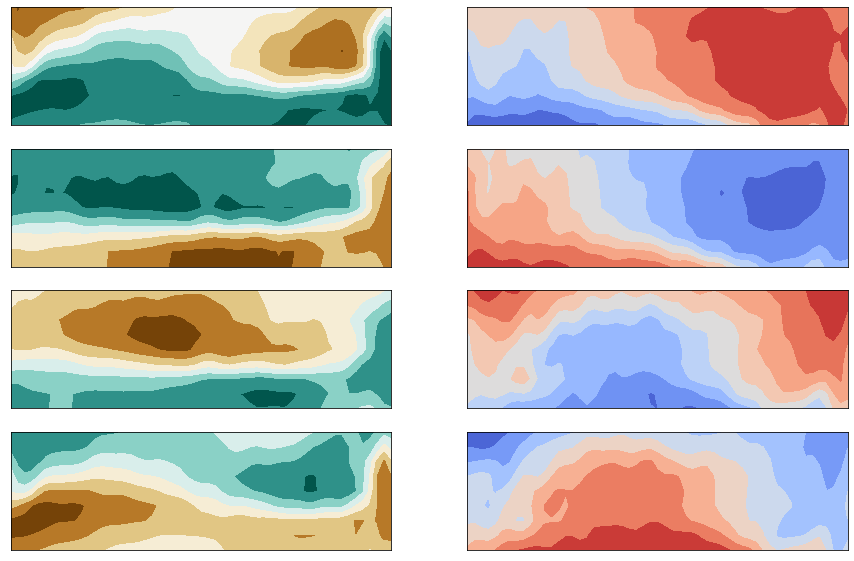

In [8]:
from cfl.visualization_methods.el_nino_vis import visualize

#NOTE: these values are el nino-specific 
FIG_KWARGS = {'figsize' : (15,10), 'facecolor' : 'white'} 
X_KWARGS = { 'cmap' : 'BrBG_r' }
Y_KWARGS = {'cmap' : 'coolwarm' }
visualize(X, Y, x_lbls=pred_results['Clusterer']['x_lbls'], 
            y_lbls=pred_results['Clusterer']['y_lbls'], fig_kwargs=FIG_KWARGS, 
            X_kwargs=X_KWARGS, Y_kwargs=Y_KWARGS)